In [1]:
import os
import sys
p = os.path.abspath('..')
if p not in sys.path:
    sys.path.append(p)
    
import pickle
import json
import tikzplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

from scipy.stats import ks_2samp
from src.lob import LOB
from src.evaluation import *
from src.table_utils import make_table

In [2]:
save_figs = False
data_type = "mc"
timestamps = ["2022_05_31_09_36", "2022_05_31_09_38", "2022_05_31_09_39", "2022_05_31_09_40", "2022_05_31_12_10"]
timefactor = 10

## Load data

In [3]:
info = []
training_info = []
for timestamp in timestamps:
    with open("../data/rnn_generated_data/{}_lob_{}_info.txt".format(data_type, timestamp), 'r') as f:
        info.append(json.load(f))

    info[-1]["model_path"] = "\\".join(info[-1]["checkpoint_path"].replace('/','\\').split("\\")[:-1]) + "\\"

    with open(info[-1]["model_path"] + "training_info.txt", 'r') as f:
        training_info.append(json.load(f))

In [5]:
data_dict_list = []
data = []
gen_data = []
data_dict = []
gen_data_dict = []
gen_data_dict_list = []

for timestamp in timestamps:
    data_dict_list.append(pickle.load( open( "../data/rnn_generated_data/{}_lob_{}.pkl".format(data_type, timestamp), "rb" ) ))
    data.append(data_dict_list[-1]['ob'])
    gen_data.append(data_dict_list[-1]['generated_ob'])
    event_types = data_dict_list[-1].pop("event_types")

    data_dict.append({})
    for k,v in data_dict_list[-1].items():
        data_dict[-1][k] = np.concatenate(data_dict_list[-1][k], axis=0)

    gen_data_dict.append({})
    for k in list(data_dict[-1].keys()):
        if k.startswith("generated_"):
            gen_data_dict[-1][k[len("generated_"):]] = data_dict[-1].pop(k)

    gen_data_dict_list.append({})
    for k in list(data_dict_list[-1].keys()):
        if k.startswith("generated_"):
            gen_data_dict_list[-1][k[len("generated_"):]] = data_dict_list[-1].pop(k) 
num_levels = data[0][0].shape[-1] - 1

## Loss during training

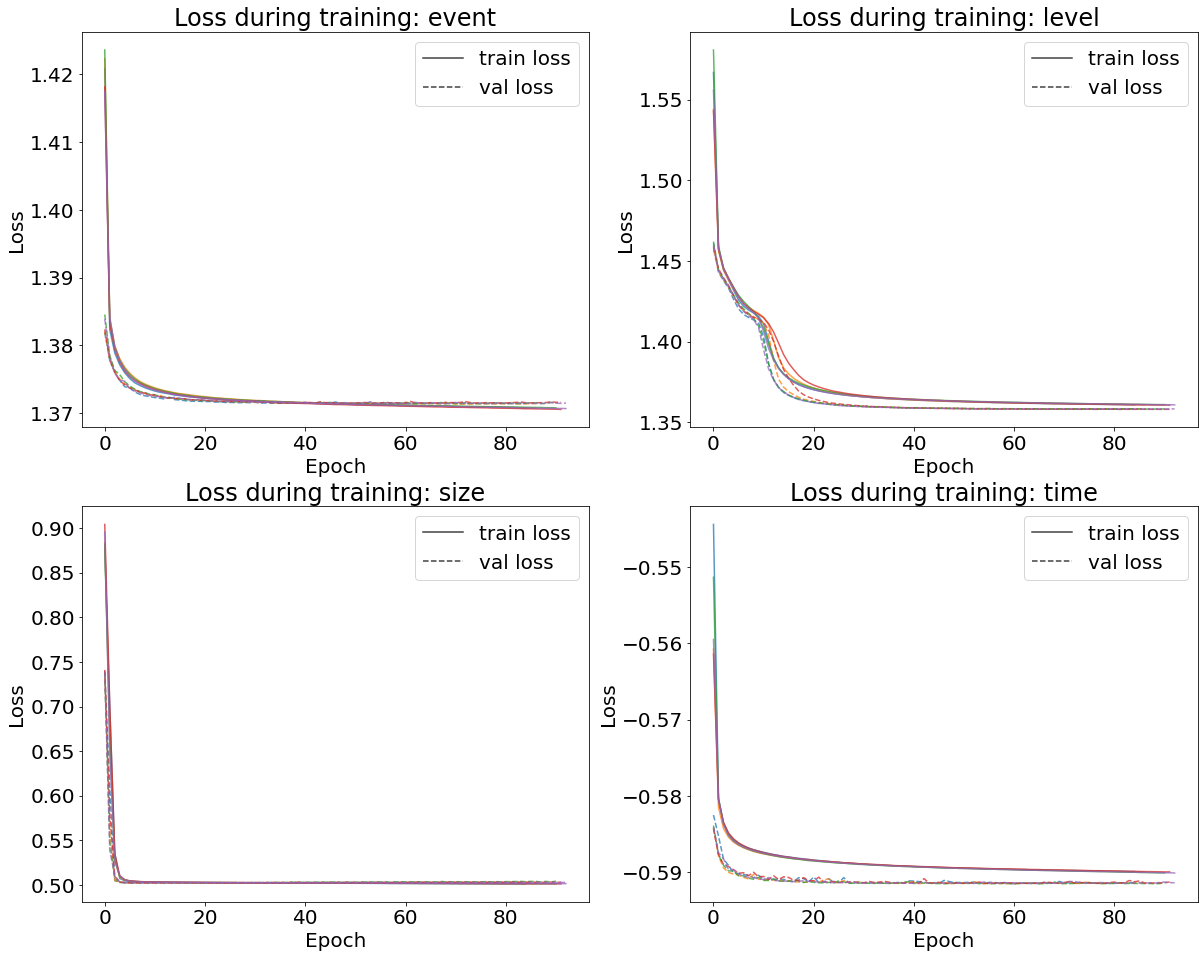

In [7]:
fig = plt.figure(figsize=[20,16])
axs = []
for t in range(len(training_info)):
    training_dict = training_info[t]
    i = 0
    for k,v in training_dict.items():
        i += 1
        if t == 0:
            axs.append(plt.subplot(2,2,i))
        p = axs[i-1].plot(np.array(v['train_loss']), alpha=0.75) #[:np.argmin(v['val_loss'])+11]
        axs[i-1].plot(np.array(v['val_loss']), '--', c=p[0].get_color(), alpha=0.75) #[:np.argmin(v['val_loss'])+11]
        if t == 0:
            axs[i-1].set_xlabel('Epoch')
            axs[i-1].set_ylabel('Loss')
            #ax1.set_yscale("log")
            axs[i-1].plot(0,v["train_loss"][0],'k', label="train loss", alpha=0.75)
            axs[i-1].plot(0,v["train_loss"][0],'--k', label="val loss", alpha=0.75)
            axs[i-1].legend()
            axs[i-1].set_title('Loss during training: ' + k);
if save_figs:
    tikzplotlib.save("images/{}_training_loss.tex".format(data_type), encoding='utf-8')
    fig.savefig("images/{}_training_loss.png".format(data_type))

## Frequencies of events

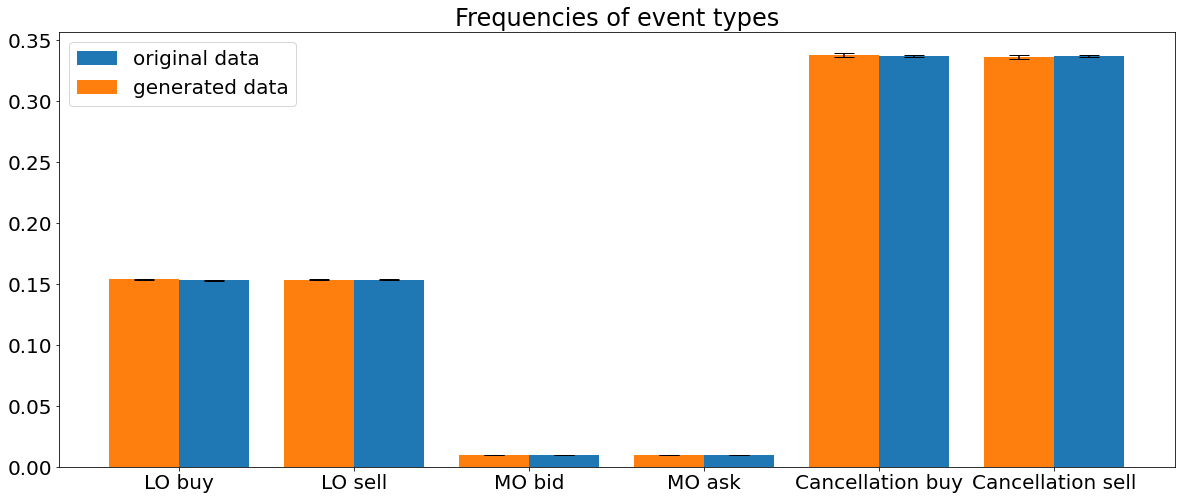

In [8]:
fig1 = plt.figure(figsize=[20,8])
ax1 = fig1.add_subplot(111)
freqs = []
for g in data_dict:
    l, v = np.unique(g["event"].reshape(-1), return_counts=True)
    freqs.append(v/np.sum(v))
freq_means = np.mean(np.stack(freqs), axis=0)
freq_std = np.std(np.stack(freqs), axis=0)
ax1.bar(np.arange(freq_means.size)+0.2, freq_means, width=0.4, yerr=freq_std, capsize=10, label="original data")
xtick_vals = ["LO buy", "LO sell", "MO bid", "MO ask", "Cancellation buy", "Cancellation sell"]
ax1.set_title("Frequencies of event types");

gen_freqs = []
for g in gen_data_dict:
    l, v = np.unique(g["event"].reshape(-1), return_counts=True)
    gen_freqs.append(v/np.sum(v))
gen_freq_means = np.mean(np.stack(gen_freqs), axis=0)
gen_freq_std = np.std(np.stack(gen_freqs), axis=0)
ax1.bar(np.arange(gen_freq_means.size)-0.2, gen_freq_means, width=0.4, yerr=gen_freq_std, capsize=10, label="generated data")

ax1.set_xticks(np.arange(len(event_types.values())))
ax1.set_xticklabels(xtick_vals)
ax1.legend();
if save_figs:
    plt.savefig("images/{}_event_type_frequencies.png".format(data_type))
    tikzplotlib.save("images/{}_event_type_frequencies.tex".format(data_type))

C:\Users\s1436ba\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


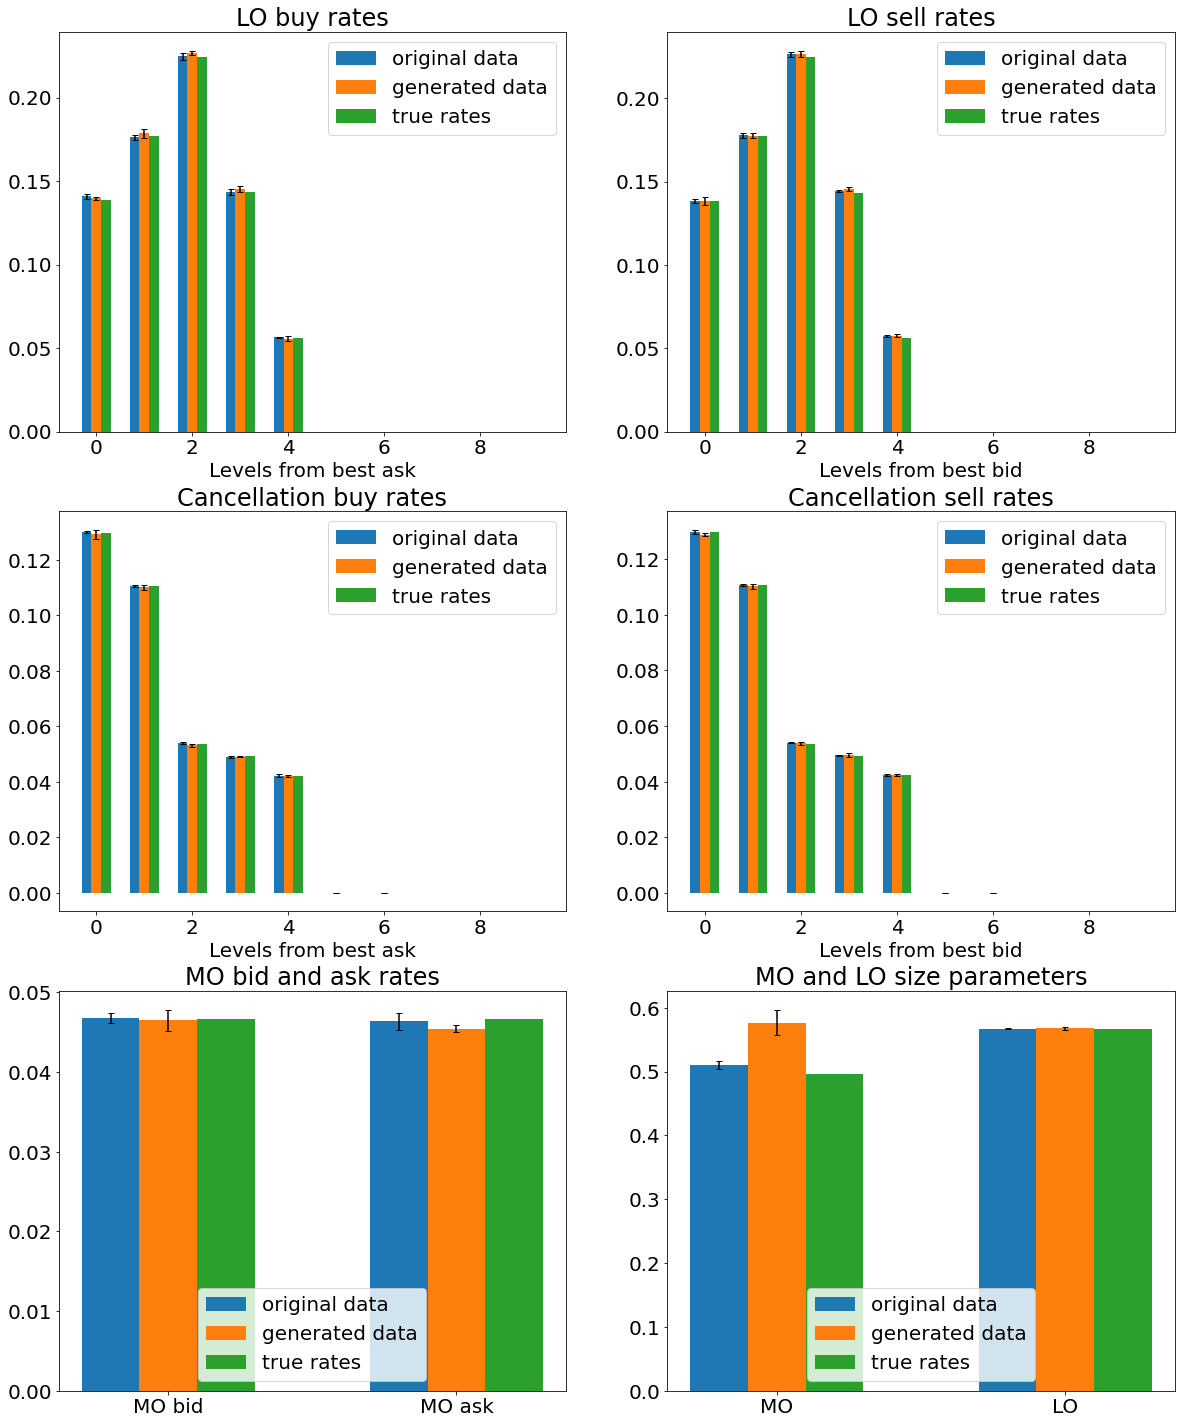

In [9]:
if data_type == "mc":
    rates = [estimate_rates_lists(d, event_types) for d in data_dict_list]
    gen_rates = [estimate_rates_lists(d, event_types) for d in gen_data_dict_list]
    with open("../data/mc_train_info.txt", 'r') as f:
        data_info = json.load(f)

    true_rates = data_info["rates"]
    true_rates["cancel buy"] = true_rates["cancellation buy"]
    true_rates["cancel sell"] = true_rates["cancellation sell"]
    
    w =.2

    fig = plt.figure(figsize=[20,25])
    s = ["lo buy", "lo sell", "cancel buy", "cancel sell"]
    s_title = ["{} rates".format(e) for e in ["LO buy", "LO sell", "Cancellation buy", "Cancellation sell"]]
    x_labels = ["Levels from best {}".format(i) for i in ["ask", "bid", "ask", "bid"]]

    for i in range(4):
        ax = plt.subplot(3,2,i+1)
        rates_s =  [r[s[i]][:10] for r in rates]
        max_len = np.max([r.size for r in rates_s])
        rates_s = [np.pad(r, (0,max_len-r.size)) for r in rates_s]
        rates_s = np.stack(rates_s)
        ax.bar(rates[0]["{} levels".format(s[i])][:max_len+1]-w, np.mean(rates_s, axis=0), yerr=np.std(rates_s, axis=0), align='center', width=w, label="original data", capsize=3)
        gen_rates_s =  [r[s[i]][:10] for r in gen_rates]
        max_len = np.max([r.size for r in gen_rates_s])
        gen_rates_s = [np.pad(r,(0,max_len-r.size)) for r in gen_rates_s]
        gen_rates_s = np.stack(gen_rates_s)
        ax.bar(np.arange(max_len), np.mean(gen_rates_s, axis=0), yerr=np.std(gen_rates_s, axis=0), align='center', width=w, label="generated data", capsize=3)
        ax.bar(np.arange(10)+w, true_rates[s[i]][:10], align='center', width=w, label="true rates")

        ax.set_title(s_title[i])
        ax.set_xlabel(x_labels[i])
        plt.legend()

    ax = plt.subplot(325)
    rates_s =  np.stack([[r["mo bid"], r["mo ask"]] for r in rates])
    ax.bar(np.arange(2)-w, np.mean(rates_s, axis=0), yerr=np.std(rates_s, axis=0), align='center', width=w, label="original data", capsize=3)
    gen_rates_s =  np.stack([[r["mo bid"], r["mo ask"]] for r in gen_rates])
    ax.bar(np.arange(2), np.mean(gen_rates_s, axis=0), yerr=np.std(gen_rates_s, axis=0), align='center', width=w, label="generated data", capsize=3)
    ax.bar(np.arange(2)+w, [true_rates["mo bid"], true_rates["mo ask"]], align='center', width=w, label="true rates")
    ax.legend()
    ax.set_title("MO bid and ask rates")
    ax.set_xticks([0,1])
    ax.set_xticklabels(["MO bid", "MO ask"])



    ax = plt.subplot(326)
    rates_s =  np.stack([[r["mo size"], r["lo size"]] for r in rates])
    ax.bar(np.arange(2)-w, np.mean(rates_s, axis=0), yerr=np.std(rates_s, axis=0), align='center', width=w, label="original data", capsize=3)
    gen_rates_s =  np.stack([[r["mo size"], r["lo size"]] for r in gen_rates])
    ax.bar(np.arange(2), np.mean(gen_rates_s, axis=0), yerr=np.std(gen_rates_s, axis=0), align='center', width=w, label="generated data", capsize=3)
    #ax.bar(np.arange(2), [gen_rates["mo size"], gen_rates["lo size"]], align='center', width=w, label="generated data")
    ax.bar(np.arange(2)+w, [true_rates["mo size"], true_rates["lo size"]], align='center', width=w, label="true rates")
    ax.legend()
    ax.set_title("MO and LO size parameters")
    ax.set_xticks([0,1])
    ax.set_xticklabels(["MO", "LO"])


    if save_figs:
        fig.savefig("images/mc_event_type_rates_detailed.png")
        tikzplotlib.save("images/mc_event_type_rates_detailed.tex", figure=fig, encoding="utf-8")
    plt.show()

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0


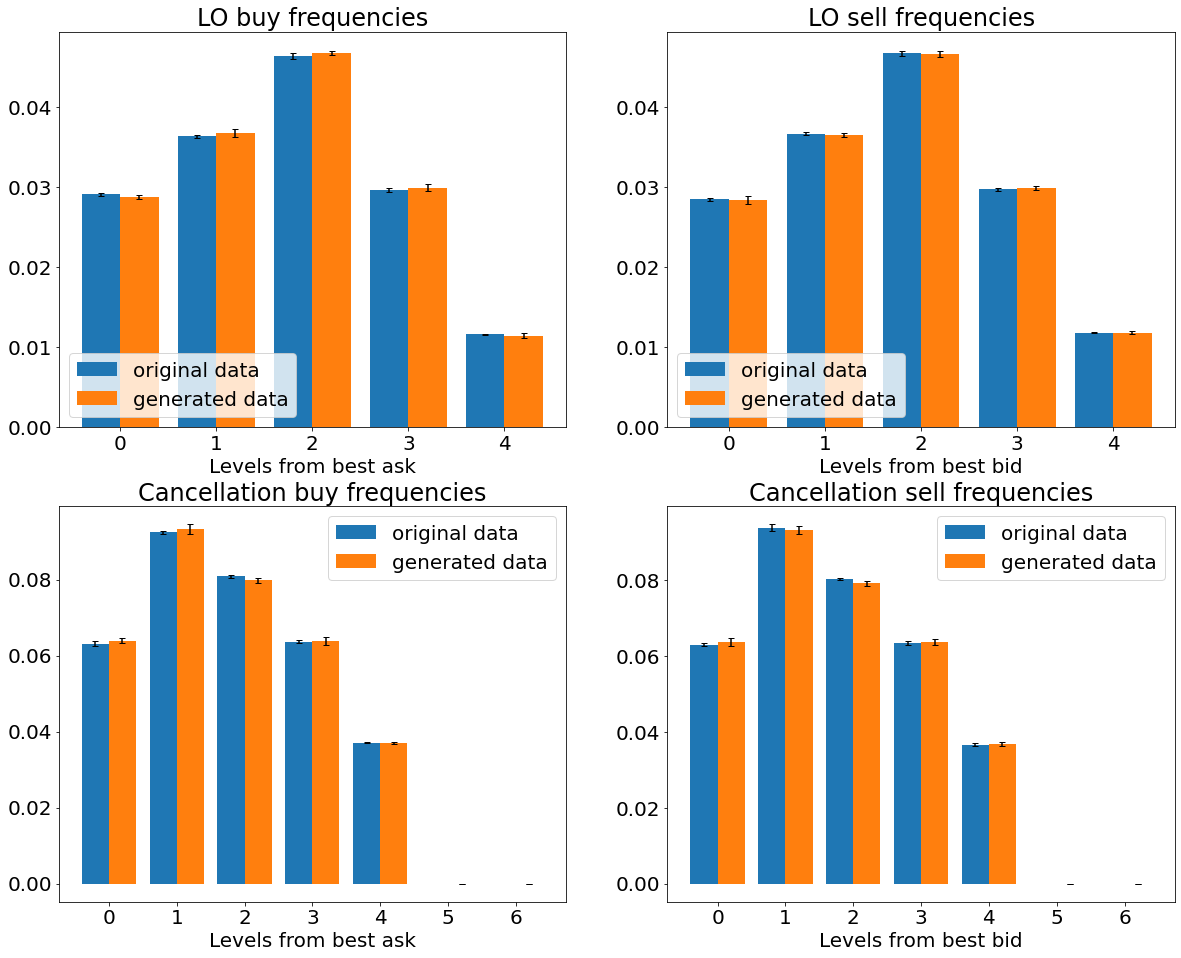

In [10]:
freq = []
gen_freq = []
for g in data_dict:
    freq.append(estimate_frequencies(g, event_types))
for g in gen_data_dict:
    gen_freq.append(estimate_frequencies(g, event_types))

w =.4

fig = plt.figure(figsize=[20,16])
s = ["lo buy", "lo sell", "cancel buy", "cancel sell"]
s_title = ["{} frequencies".format(e) for e in ["LO buy", "LO sell", "Cancellation buy", "Cancellation sell"]]
x_labels = ["Levels from best {}".format(i) for i in ["ask", "bid", "ask", "bid"]]

for i in range(4):
    ax = plt.subplot(2,2,i+1)
    freq_s =  [f[s[i]][:10] for f in freq]
    max_len = np.max([r.size for r in freq_s])
    freq_s = [np.pad(r, (0,max_len-r.size)) for r in freq_s]
    freq_s = np.stack(freq_s)
    freq_means = np.mean(freq_s, axis=0)
    freq_std = np.std(freq_s, axis=0)
    gen_freq_s =  [f[s[i]][:10] for f in gen_freq]
    max_len = np.max([r.size for r in gen_freq_s])
    gen_freq_s = [np.pad(r, (0,max_len-r.size)) for r in gen_freq_s]
    gen_freq_s = np.stack(gen_freq_s)
    gen_freq_means = np.mean(gen_freq_s, axis=0)
    gen_freq_std = np.std(gen_freq_s, axis=0)
    ax.bar(freq[0]["{} levels".format(s[i])][:max_len]-w/2, freq_means, yerr = freq_std, align='center', width=w, label="original data", capsize=3)
    ax.bar(np.arange(max_len)+w/2, gen_freq_means, yerr = gen_freq_std, align='center', width=w, label="generated data",  capsize=3)
    ax.set_title(s_title[i])
    ax.set_xlabel(x_labels[i])
    plt.legend()

if save_figs:
    fig.savefig("images/{}_event_type_frequencies_detailed.png".format(data_type))
    tikzplotlib.save("images/{}_event_type_frequencies_detailed.tex".format(data_type), encoding="utf-8")
plt.show()

## Mid and spreads

In [11]:
def normalized_func(data, func, start_value=0):
    p = np.apply_along_axis(func,-1,data.reshape((data.shape[:-2] + (-1,))))
    p = p - p[:,0].reshape(-1,1) + start_value
    return p

fun_list = [lambda d: normalized_func(d, lambda x: LOB(x).mid), lambda d: normalized_func(d, lambda x: LOB(x).microprice)]
data_list = [data, gen_data]
titles = ["Midprice", "Microprice"]
data_labels = ["original data", "generated data"]
end_time = info[0]["seq_length_time"]
time_str = "time" if data_type == "mc" else "abs_time"
data_time_list = [np.concatenate([events_to_times(d["ob"][i].reshape((1,-1,2,num_levels+1)), d[time_str][i].reshape((1,-1)), timefactor=timefactor, end_time=end_time) for i in range(len(d["event"]))]) for d in data_dict_list] 
gen_data_time_list = [np.concatenate([events_to_times(d["ob"][i].reshape((1,-1,2,num_levels+1)), d[time_str][i].reshape((1,-1)), timefactor=timefactor, end_time=end_time) for i in range(len(d["event"]))]) for d in gen_data_dict_list]

In [12]:
data_spreads = [np.apply_along_axis(lambda x: LOB(x).spread,-1,d.reshape(d.shape[:-2] + (-1,))) for d in data_time_list]
gen_data_spreads = [np.apply_along_axis(lambda x: LOB(x).spread,-1,d.reshape(d.shape[:-2] + (-1,))) for d in gen_data_time_list]

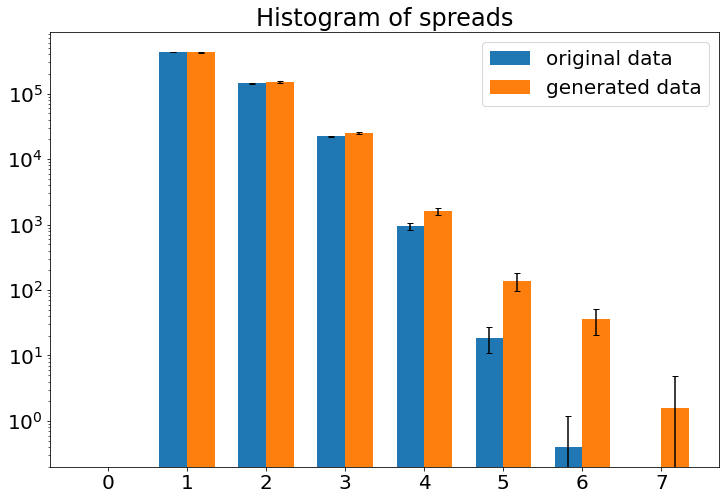

In [13]:
freqs = []
for d in data_spreads:
    v = np.bincount(d.reshape(-1), minlength=np.max(data_spreads)+1)
    freqs.append(v)
freq_means = np.mean(np.stack(freqs), axis=0)
freq_std = np.std(np.stack(freqs), axis=0)
w =.35
fig = plt.figure(figsize=[12,8])
ax = plt.subplot(111)
ax.bar(np.arange(freq_means.size)-w/2,freq_means, yerr=freq_std, align='center', width=w, log=True, label="original data", capsize=3)


freqs = []
for d in gen_data_spreads:
    v = np.bincount(d.reshape(-1), minlength=np.max(gen_data_spreads)+1)
    freqs.append(v)
freq_means = np.mean(np.stack(freqs), axis=0)
freq_std = np.std(np.stack(freqs), axis=0)
ax.bar(np.arange(freq_means.size)+w/2,freq_means, yerr=freq_std, align='center', width=w, log=True, label="generated data", capsize=3)
ax.set_title("Histogram of spreads")
plt.legend()
plt.show()
if save_figs:
    fig.savefig("images/{}_spread_histogram.png".format(data_type))
    tikzplotlib.save("images/{}_spread_histogram.tex".format(data_type))

In [14]:
lineplot_time_list = [data_time_list, gen_data_time_list]
def agg_fun(fun):
    num_overall = len(lineplot_time_list)
    num_data = len(lineplot_time_list[0])
    df_list = [[[] for _ in range(num_data)] for _ in range(num_overall)]

    for i in range(num_overall):
        for j in range(num_data):
            df_list[i][j] = pd.DataFrame(fun(lineplot_time_list[i][j]))
            df_list[i][j]['index'] = df_list[i][j].index
            df_list[i][j] = pd.melt(df_list[i][j], id_vars='index', value_name="fun", var_name='point')
            df_list[i][j]['timepoint'] = df_list[i][j]['point'] / timefactor

    grouped = [[d.groupby("timepoint")["fun"].agg(['mean', 'std']) for d in dd] for dd in df_list]

    return grouped

In [15]:
fun = lambda d: np.apply_along_axis(lambda x: LOB(x).spread,-1,d.reshape(d.shape[:-2] + (-1,)))
grouped = agg_fun(fun)

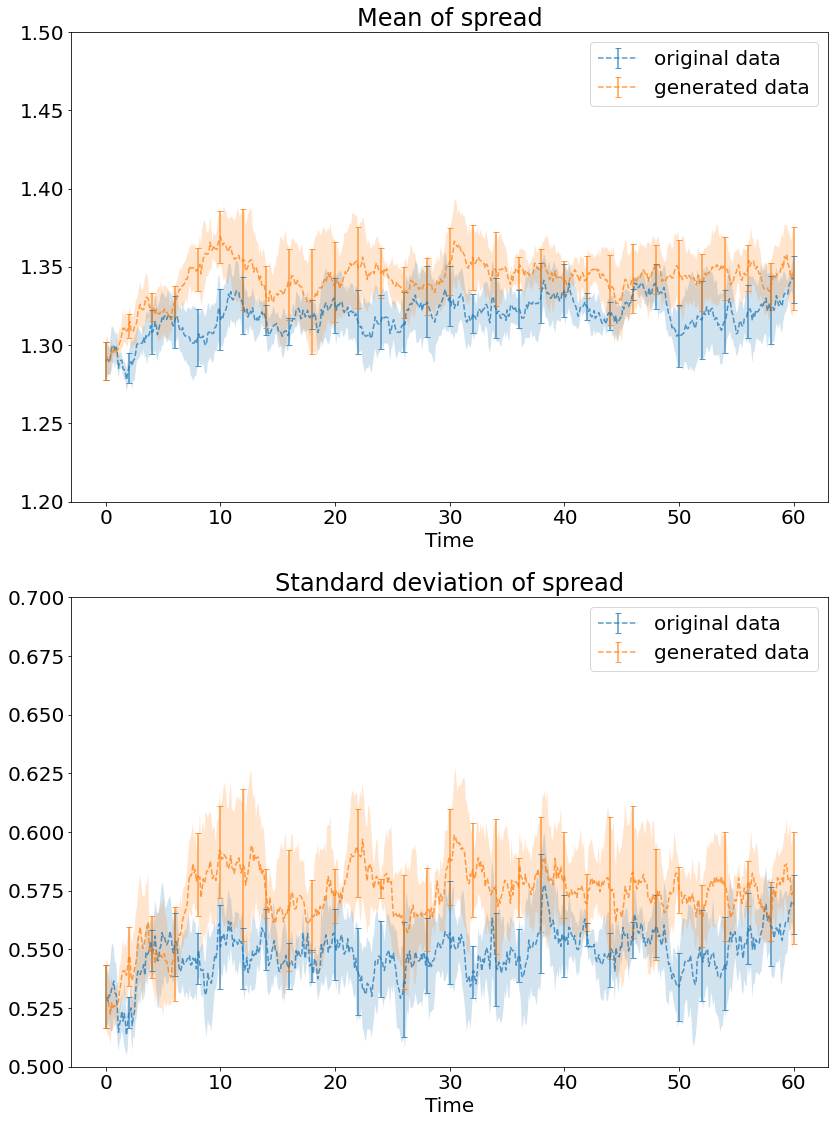

In [16]:
fig = plt.figure(figsize=[12, 16])
axs = [fig.add_subplot(2,1,i+1) for i in range(2)]
num_overall = len(lineplot_time_list)
for i in range(num_overall):
    mean_vals = pd.concat(grouped[i], keys=np.arange(len(g))).groupby("timepoint")["mean"].agg(["mean", "std"])
    axs[0].errorbar(mean_vals.index, mean_vals["mean"], yerr=mean_vals["std"], label=data_labels[i], errorevery=20, capsize=3, alpha=.75, fmt="--")
    axs[0].fill_between(mean_vals.index, mean_vals["mean"]-mean_vals["std"], mean_vals["mean"]+mean_vals["std"], alpha=0.2)
    
    std_vals = pd.concat(grouped[i], keys=np.arange(len(g))).groupby("timepoint")["std"].agg(["mean", "std"])
    axs[1].errorbar(std_vals.index, std_vals["mean"], yerr=std_vals["std"], label=data_labels[i], errorevery=20, capsize=3, alpha=.75, fmt="--")
    axs[1].fill_between(std_vals.index, std_vals["mean"]-std_vals["std"], std_vals["mean"]+std_vals["std"], alpha=0.2)
    
if data_type == "mc":
    axs[0].set_ylim((1.2,1.5))
    axs[1].set_ylim((0.5,0.7))
else: 
    axs[0].set_ylim((1.9,2.2))
    axs[1].set_ylim((0.7,0.9))

titles = ["Mean of spread", "Standard deviation of spread"]
for t in range(len(titles)):
    axs[t].set_title(titles[t])
    axs[t].legend()#loc='lower left')
    axs[t].set_xlabel("Time")

fig.tight_layout()
plt.legend();
if save_figs:
    fig.savefig("images/{}_spread_mean.png".format(data_type))
    tikzplotlib.save("images/{}_spread_mean.tex".format(data_type))

In [17]:
fun = lambda d: normalized_func(d, lambda x: LOB(x).mid)
grouped = agg_fun(fun)

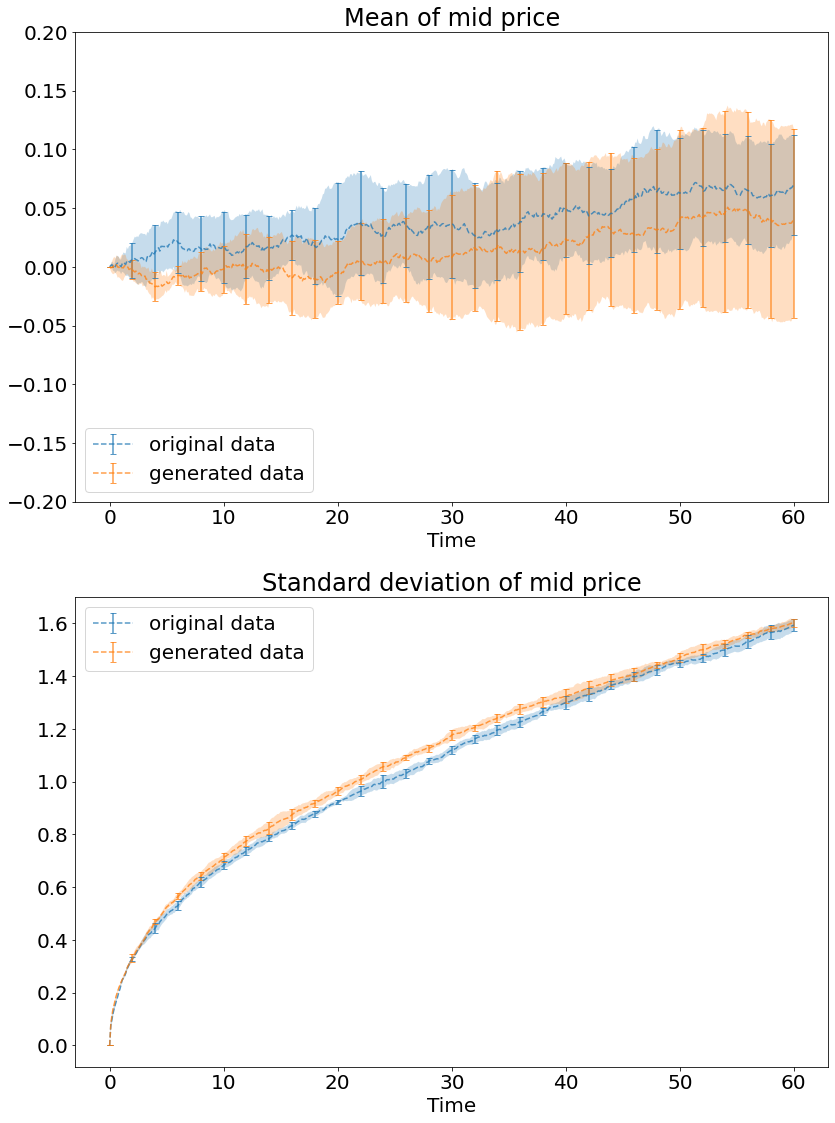

In [18]:
fig = plt.figure(figsize=[12, 16])
axs = [fig.add_subplot(2,1,i+1) for i in range(2)]
for i in range(num_overall):
    mean_vals = pd.concat(grouped[i], keys=np.arange(len(g))).groupby("timepoint")["mean"].agg(["mean", "std"])
    axs[0].errorbar(mean_vals.index, mean_vals["mean"], yerr=mean_vals["std"], label=data_labels[i], errorevery=20, capsize=3, alpha=.75, fmt="--")
    axs[0].fill_between(mean_vals.index, mean_vals["mean"]-mean_vals["std"], mean_vals["mean"]+mean_vals["std"], alpha=0.25)
    
    std_vals = pd.concat(grouped[i], keys=np.arange(len(g))).groupby("timepoint")["std"].agg(["mean", "std"])
    axs[1].errorbar(std_vals.index, std_vals["mean"], yerr=std_vals["std"], label=data_labels[i], errorevery=20, capsize=3, alpha=.75, fmt="--")
    axs[1].fill_between(std_vals.index, std_vals["mean"]-std_vals["std"], std_vals["mean"]+std_vals["std"], alpha=0.25)
    
axs[0].set_ylim((-0.2,0.2))
#axs[1].set_ylim((0.7,0.9))
titles = ["Mean of mid price", "Standard deviation of mid price"]
for t in range(len(titles)):
    axs[t].set_title(titles[t])
    axs[t].legend(loc='lower left')
    axs[t].set_xlabel("Time")

fig.tight_layout()
plt.legend();

if save_figs:
    fig.savefig("images/{}_mid_mean_time.png".format(data_type))
    tikzplotlib.save("images/{}_mid_mean_time.tex".format(data_type), encoding="utf-8")

## Order imbalance

In [19]:
num_bins = 49
depth = 5
num_regimes = 5

In [20]:
num_data = len(data_time_list)
oi = [np.apply_along_axis(lambda x: LOB(x).order_imbalance(depth), -1,
                          d[:, :-1, ...].reshape((d.shape[0], d.shape[1] - 1, -1))) for d in data_time_list]
gen_oi = [np.apply_along_axis(lambda x: LOB(x).order_imbalance(depth), -1,
                          d[:, :-1, ...].reshape((d.shape[0], d.shape[1] - 1, -1))) for d in gen_data_time_list]

bins = (2 * np.arange(0, num_bins + 1) / num_bins) - 1

In [21]:
freqs = np.stack([np.histogram(o, bins=bins, density=True)[0] for o in oi])
gen_freqs = np.stack([np.histogram(o, bins=bins, density=True)[0] for o in gen_oi])

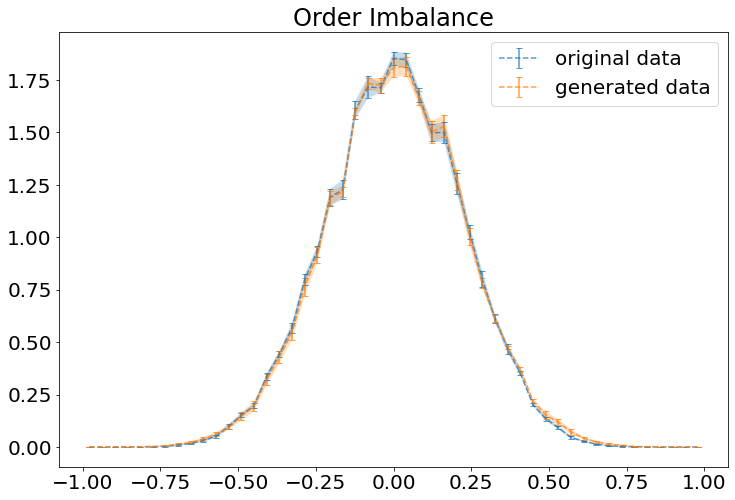

In [22]:
fig1 = plt.figure(figsize=[12, 8])
plt.errorbar((bins[1:] + bins[:-1])/2, np.mean(freqs, axis=0), yerr=np.std(freqs, axis=0), alpha=.75, fmt="--", capsize=3, label=data_labels[0])
plt.fill_between((bins[1:] + bins[:-1])/2, np.mean(freqs, axis=0)-np.std(freqs, axis=0), np.mean(freqs, axis=0)+np.std(freqs, axis=0), alpha=.25)
plt.errorbar((bins[1:] + bins[:-1])/2, np.mean(gen_freqs, axis=0), yerr=np.std(gen_freqs, axis=0), alpha=.75, fmt="--", capsize=3, label=data_labels[1])
plt.fill_between((bins[1:] + bins[:-1])/2, np.mean(gen_freqs, axis=0)-np.std(gen_freqs, axis=0), np.mean(gen_freqs, axis=0)+np.std(gen_freqs, axis=0), alpha=0.25)
plt.title("Order Imbalance")
plt.legend();
if save_figs:
    fig1.savefig("images/{}_oib_histogram.png".format(data_type))
    tikzplotlib.save("images/{}_oib_histogram.tex".format(data_type), encoding="utf-8")

In [23]:
oi_bins = (2 * np.arange(0, num_regimes + 1) / num_regimes) - 1
oi_bins[-1] += 1e-15
oi_ind = [np.digitize(o, oi_bins) for o in oi]
gen_oi_ind = [np.digitize(o, oi_bins) for o in gen_oi]

df_trans = [[]] * num_data
df_oi = [0] * num_data
gen_df_trans = [[]] * num_data
gen_df_oi = [0] * num_data

for j in range(num_data):
    for i in range(oi_ind[j].shape[0]):
        df_trans[j].append(pd.crosstab(pd.Series(oi_ind[j][i, 1:], name='Tomorrow'),
                                       pd.Series(oi_ind[j][i, :-1], name='Today'), normalize=1))
        gen_df_trans[j].append(pd.crosstab(pd.Series(gen_oi_ind[j][i, 1:], name='Tomorrow'),
                                       pd.Series(gen_oi_ind[j][i, :-1], name='Today'), normalize=1))

    df_oi[j] = pd.concat(df_trans[j]).fillna(0).groupby(level=0).sum()
    df_oi[j] = df_oi[j] / df_oi[j].sum()
    df_oi[j] = df_oi[j].sort_index(axis=0).sort_index(axis=1)
    gen_df_oi[j] = pd.concat(gen_df_trans[j]).fillna(0).groupby(level=0).sum()
    gen_df_oi[j] = gen_df_oi[j] / gen_df_oi[j].sum()
    gen_df_oi[j] = gen_df_oi[j].sort_index(axis=0).sort_index(axis=1)
    
df_diff = [df_oi[j] - gen_df_oi[j] for j in range(num_data)]
df_oi_mean = np.mean(np.stack(df_oi), axis=0)
df_oi_std = np.std(np.stack(df_oi), axis=0)
gen_df_oi_mean = np.mean(np.stack(gen_df_oi), axis=0)
gen_df_oi_std = np.std(np.stack(gen_df_oi), axis=0)
diff_oi_mean = np.mean(np.stack(df_diff), axis=0)
diff_oi_std = np.std(np.stack(df_diff), axis=0)

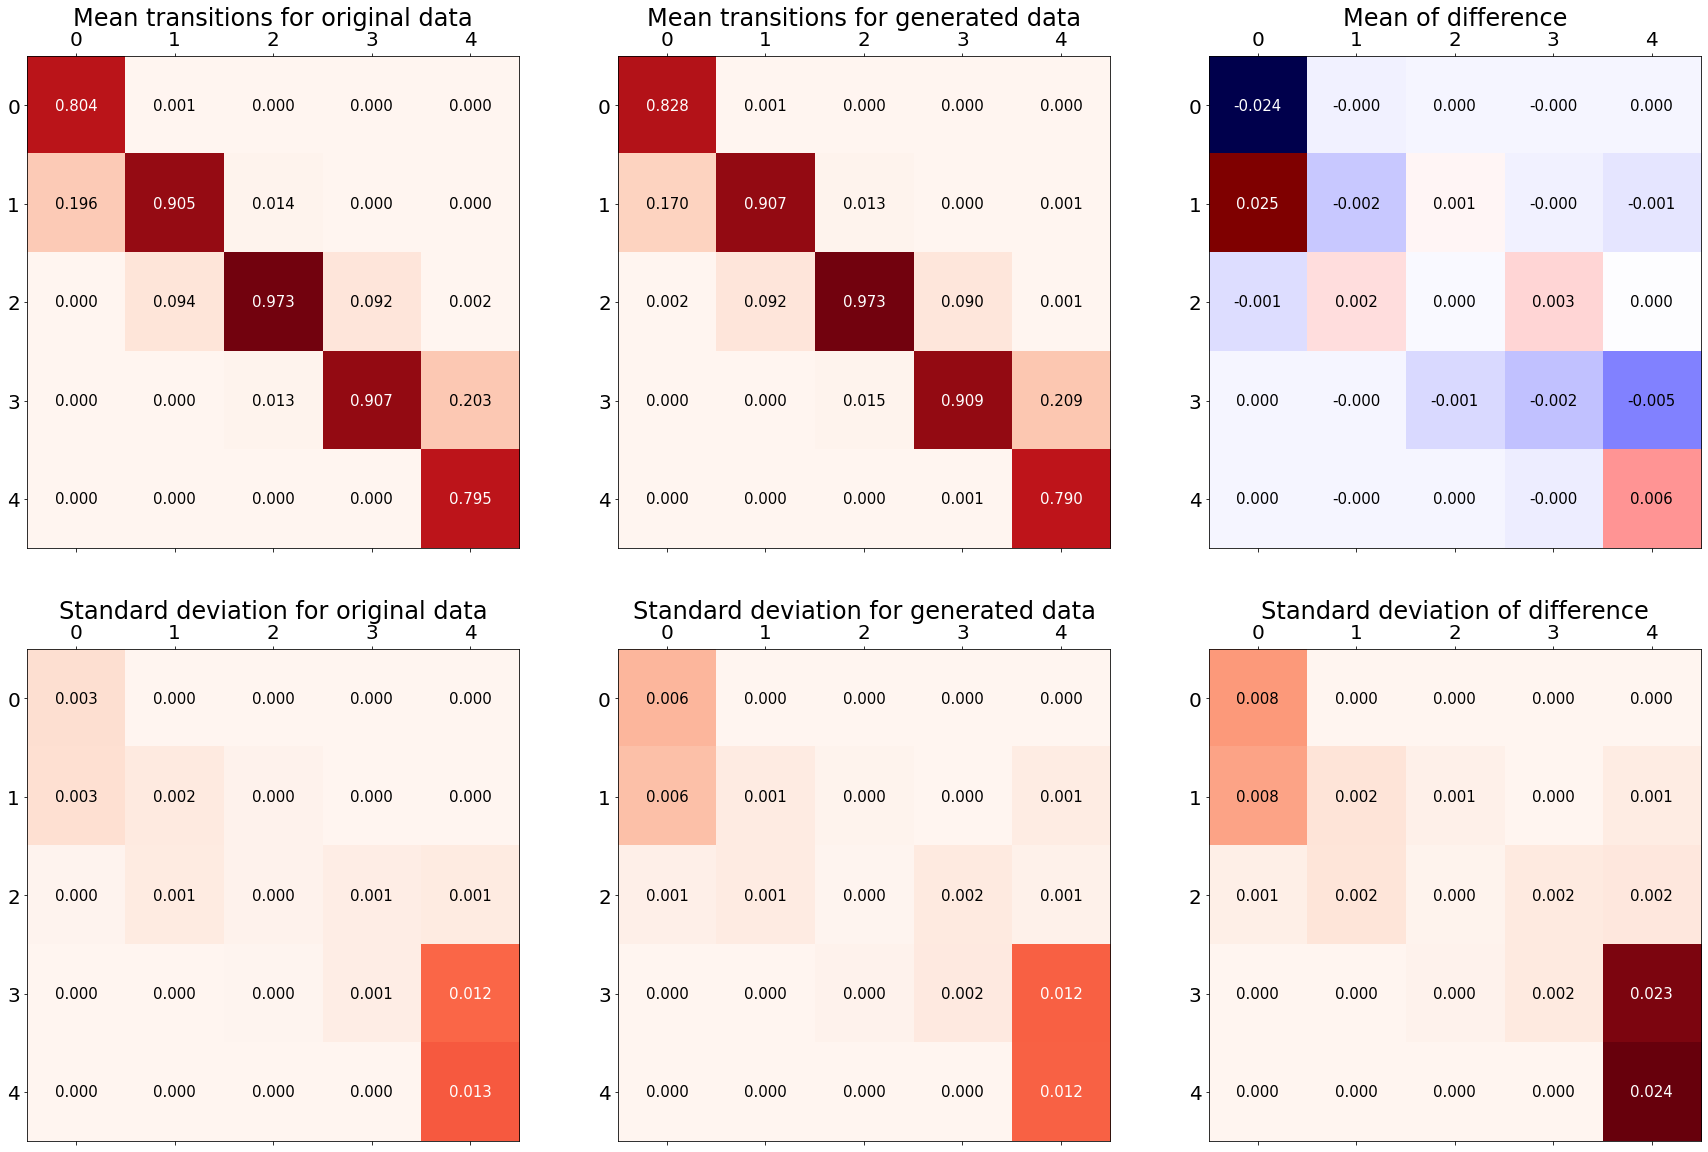

In [24]:
fig2 = plt.figure(figsize=(30, 20))
axs = [fig2.add_subplot(2, 3, d + 1) for d in range(6)]

threshold = 0.5
textcolors = ("black", "white")
axs[0].matshow(df_oi_mean, cmap='Reds', vmin=0, vmax=1)
for (i, j), z in np.ndenumerate(df_oi_mean):
    color = textcolors[int(df_oi_mean[i, j] > threshold)]
    axs[0].text(j, i, '{:0.3f}'.format(z), ha='center', va='center', color=color, size=15)
axs[0].set_title("Mean transitions for {}".format(data_labels[0]))
axs[1].matshow(gen_df_oi_mean, cmap='Reds', vmin=0, vmax=1)
for (i, j), z in np.ndenumerate(gen_df_oi_mean):
    color = textcolors[int(gen_df_oi_mean[i, j] > threshold)]
    axs[1].text(j, i, '{:0.3f}'.format(z), ha='center', va='center', color=color, size=15)
axs[1].set_title("Mean transitions for {}".format(data_labels[1]))
axs[2].matshow(diff_oi_mean, cmap='seismic')
threshold = (np.max(diff_oi_mean) - np.min(diff_oi_mean))/4
for (i, j), z in np.ndenumerate(diff_oi_mean):
    color = textcolors[int(diff_oi_mean[i, j] > threshold) + int(diff_oi_mean[i, j] < -threshold)]
    axs[2].text(j, i, '{:0.3f}'.format(z), ha='center', va='center', color=color, size=15)
axs[2].set_title("Mean of difference")
vmin = 0
vmax = np.max([df_oi_std, gen_df_oi_std, diff_oi_std])
threshold = vmax/2
axs[3].matshow(df_oi_std, cmap='Reds', vmin=vmin, vmax=vmax)
for (i, j), z in np.ndenumerate(df_oi_std):
    color = textcolors[int(df_oi_std[i, j] > threshold)]
    axs[3].text(j, i, '{:0.3f}'.format(z), ha='center', va='center', color=color, size=15)
axs[3].set_title("Standard deviation for {}".format(data_labels[0]))
axs[4].matshow(gen_df_oi_std, cmap='Reds', vmin=vmin, vmax=vmax)
for (i, j), z in np.ndenumerate(gen_df_oi_std):
    color = textcolors[int(gen_df_oi_std[i, j] > threshold)]
    axs[4].text(j, i, '{:0.3f}'.format(z), ha='center', va='center', color=color, size=15)
axs[4].set_title("Standard deviation for {}".format(data_labels[1]))
axs[5].matshow(diff_oi_std, cmap='Reds', vmin=vmin, vmax=vmax)
for (i, j), z in np.ndenumerate(diff_oi_std):
    color = textcolors[int(gen_df_oi_std[i, j] > threshold)]
    axs[5].text(j, i, '{:0.3f}'.format(z), ha='center', va='center', color=color, size=15)
axs[5].set_title("Standard deviation of difference");
if save_figs:
    fig2.savefig("images/{}_oib_transitions.png".format(data_type))
    tikzplotlib.save("images/{}_oib_transitions.tex".format(data_type), encoding="utf-8")

## Distribution of returns

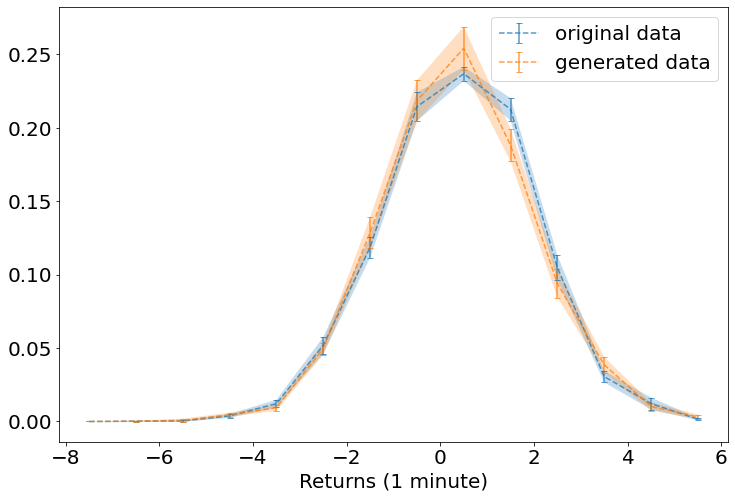

In [25]:
returns = [[LOB(ob[-1,...]).mid - LOB(ob[0,...]).mid for ob in d["ob"]] for d in data_dict_list]
gen_returns = [[LOB(ob[-1,...]).mid - LOB(ob[0,...]).mid for ob in d["ob"]] for d in gen_data_dict_list]
max_returns = np.max([returns, gen_returns])
min_returns = np.min([returns, gen_returns])
bins = np.arange(min_returns-1,max_returns+1,1)
bin_width = bins[1] - bins[0]
freqs = np.stack([np.histogram(e, density=True, bins=bins)[0] for e in returns])
gen_freqs = np.stack([np.histogram(e, density=True, bins=bins)[0] for e in gen_returns])
fig1 = plt.figure(figsize=[12, 8])
plt.errorbar((bins[1:] + bins[:-1])/2, np.mean(freqs, axis=0), yerr=np.std(freqs, axis=0), alpha=.75, fmt="--", capsize=3, label=data_labels[0])
plt.fill_between((bins[1:] + bins[:-1])/2, np.mean(freqs, axis=0)-np.std(freqs, axis=0), np.mean(freqs, axis=0)+np.std(freqs, axis=0), alpha=.25)
plt.errorbar((bins[1:] + bins[:-1])/2, np.mean(gen_freqs, axis=0), yerr=np.std(gen_freqs, axis=0), alpha=.75, fmt="--", capsize=3, label=data_labels[1])
plt.fill_between((bins[1:] + bins[:-1])/2, np.mean(gen_freqs, axis=0)-np.std(gen_freqs, axis=0), np.mean(gen_freqs, axis=0)+np.std(gen_freqs, axis=0), alpha=0.25);
plt.legend();
plt.xlabel("Returns (1 minute)");
if save_figs:
    fig.savefig("images/{}_returns.png".format(data_type))
    tikzplotlib.save("images/{}_returns.tex".format(data_type), encoding="utf-8")

In [26]:
mid_func = lambda d: np.apply_along_axis(lambda x: LOB(x).mid,-1,d.reshape((d.shape[:-2] + (-1,))))
data_mids = [mid_func(d) for d in data_time_list]
gen_data_mids = [mid_func(d) for d in gen_data_time_list]

data_return = [np.diff(d, axis=-1) for d in data_mids]
gen_data_return = [np.diff(d, axis=-1) for d in gen_data_mids]

In [27]:
returns_10 = [np.diff(d[:,np.arange(0,info[0]["seq_length_time"]*timefactor+1,10*timefactor)],axis=-1) for d in data_mids]
gen_returns_10 = [np.diff(d[:,np.arange(0,info[0]["seq_length_time"]*timefactor+1,10*timefactor)],axis=-1) for d in gen_data_mids]
autocorrelations = [np.zeros(r.shape[0]) for r in returns_10]
gen_autocorrelations = [np.zeros(r.shape[0]) for r in gen_returns_10]
for j in range(num_data):
    for i in range(returns_10[j].shape[0]):
        autocorrelations[j][i] = np.corrcoef(returns_10[j][i,:-1], returns_10[j][i,1:])[1,0]
        gen_autocorrelations[j][i] = np.corrcoef(gen_returns_10[j][i,:-1], gen_returns_10[j][i,1:])[1,0]

C:\Users\s1436ba\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\s1436ba\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [28]:
volumes = [np.zeros_like(r) for r in returns_10]
for n in range(num_data):
    for i in range(volumes[n].shape[0]):
        last_index = 0
        cumsum_time = np.cumsum(data_dict_list[n]["time"][i][1:]) 
        sizes = data_dict_list[n]["size"][i][1:]
        for j in range(volumes[n].shape[1]):
            if j < (volumes[n].shape[1]-1):
                next_index = np.argmax(cumsum_time > 10*(j+1))
            else:
                next_index = sizes.size
            volumes[n][i,j] = np.sum(np.abs(sizes[last_index:next_index]))
            last_index = next_index
        
gen_volumes = [np.zeros_like(r) for r in returns_10]
for n in range(num_data):
    for i in range(gen_volumes[n].shape[0]):
        last_index = 0
        cumsum_time = np.cumsum(gen_data_dict_list[n]["time"][i][1:]) 
        sizes = gen_data_dict_list[n]["size"][i][1:]
        for j in range(gen_volumes[n].shape[1]):
            if j < (gen_volumes[n].shape[1]-1):
                next_index = np.argmax(cumsum_time > 10*(j+1))
            else:
                next_index = sizes.size
            gen_volumes[n][i,j] = np.sum(np.abs(sizes[last_index:next_index]))
            last_index = next_index

In [29]:
returns_1 = [np.diff(d[:,np.arange(0,info[0]["seq_length_time"]*timefactor+1,1*timefactor)],axis=-1) for d in data_mids]
gen_returns_1 = [np.diff(d[:,np.arange(0,info[0]["seq_length_time"]*timefactor+1,1*timefactor)],axis=-1) for d in gen_data_mids]
vol_10 = [np.stack([np.std(r[:, 10*i:10*(i+1)], axis=-1) for i in range(6)], axis=1) for r in returns_1]
gen_vol_10 = [np.stack([np.std(r[:, 10*i:10*(i+1)], axis=-1) for i in range(6)], axis=1) for r in gen_returns_1]
vol_correlations = [np.zeros(r.shape[0]) for r in returns_10]
gen_vol_correlations = [np.zeros(r.shape[0]) for r in gen_returns_10]
for n in range(num_data):
    for i in range(returns_10[n].shape[0]):
        vol_correlations[n][i] = np.corrcoef(vol_10[n][i,:], volumes[n][i,:])[1,0]
        gen_vol_correlations[n][i] = np.corrcoef(gen_vol_10[n][i,:], gen_volumes[n][i,:])[1,0]

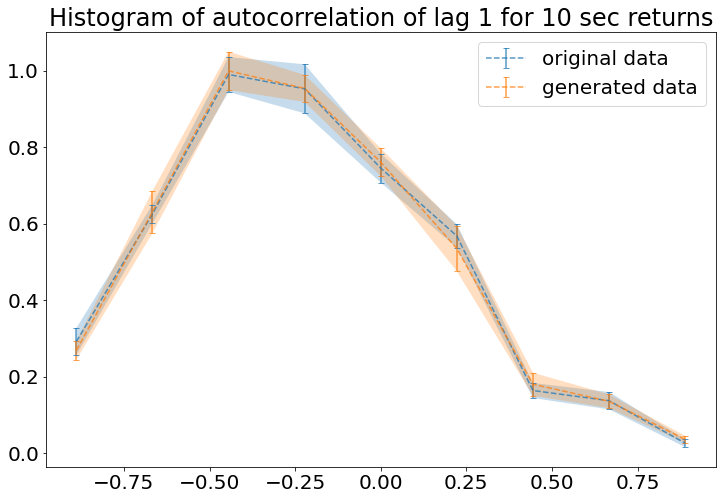

In [30]:
bins = np.linspace(-1,1,10)
bin_width = bins[1] - bins[0]
freqs = np.stack([np.histogram(e, density=True, bins=bins)[0] for e in autocorrelations])
gen_freqs = np.stack([np.histogram(e, density=True, bins=bins)[0] for e in gen_autocorrelations])
fig1 = plt.figure(figsize=[12, 8])
plt.errorbar((bins[1:] + bins[:-1])/2, np.mean(freqs, axis=0), yerr=np.std(freqs, axis=0), alpha=.75, fmt="--", capsize=3, label=data_labels[0])
plt.fill_between((bins[1:] + bins[:-1])/2, np.mean(freqs, axis=0)-np.std(freqs, axis=0), np.mean(freqs, axis=0)+np.std(freqs, axis=0), alpha=.25)
plt.errorbar((bins[1:] + bins[:-1])/2, np.mean(gen_freqs, axis=0), yerr=np.std(gen_freqs, axis=0), alpha=.75, fmt="--", capsize=3, label=data_labels[1])
plt.fill_between((bins[1:] + bins[:-1])/2, np.mean(gen_freqs, axis=0)-np.std(gen_freqs, axis=0), np.mean(gen_freqs, axis=0)+np.std(gen_freqs, axis=0), alpha=0.25);
plt.legend();
plt.title("Histogram of autocorrelation of lag 1 for 10 sec returns");
if save_figs:
    fig.savefig("images/{}_autocorrelation.png".format(data_type))
    tikzplotlib.save("images/{}_autocorrelation.tex".format(data_type), encoding="utf-8")

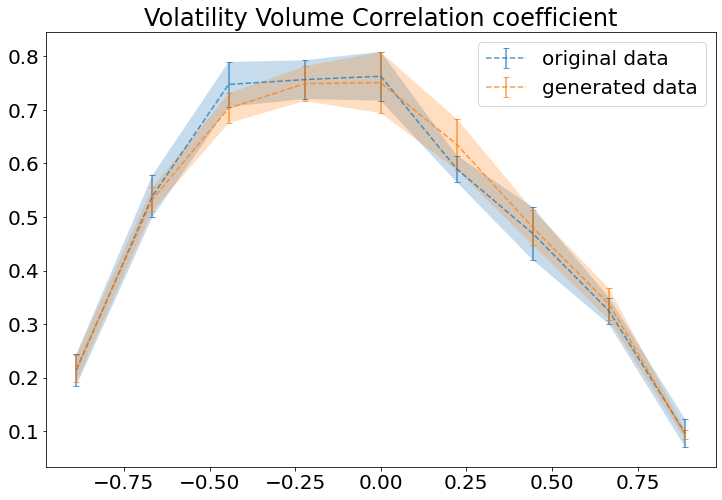

In [31]:
bins = np.linspace(-1,1,10)
bin_width = bins[1] - bins[0]
freqs = np.stack([np.histogram(e, density=True, bins=bins)[0] for e in vol_correlations])
gen_freqs = np.stack([np.histogram(e, density=True, bins=bins)[0] for e in gen_vol_correlations])
fig1 = plt.figure(figsize=[12, 8])
plt.errorbar((bins[1:] + bins[:-1])/2, np.mean(freqs, axis=0), yerr=np.std(freqs, axis=0), alpha=.75, fmt="--", capsize=3, label=data_labels[0])
plt.fill_between((bins[1:] + bins[:-1])/2, np.mean(freqs, axis=0)-np.std(freqs, axis=0), np.mean(freqs, axis=0)+np.std(freqs, axis=0), alpha=.25)
plt.errorbar((bins[1:] + bins[:-1])/2, np.mean(gen_freqs, axis=0), yerr=np.std(gen_freqs, axis=0), alpha=.75, fmt="--", capsize=3, label=data_labels[1])
plt.fill_between((bins[1:] + bins[:-1])/2, np.mean(gen_freqs, axis=0)-np.std(gen_freqs, axis=0), np.mean(gen_freqs, axis=0)+np.std(gen_freqs, axis=0), alpha=0.25);
plt.legend();
plt.title("Volatility Volume Correlation coefficient");
if save_figs:
    fig.savefig("images/{}_volatility_volume.png".format(data_type))
    tikzplotlib.save("images/{}_volatility_volume.tex".format(data_type), encoding="utf-8")

In [32]:
lagged_autocorrelations = [np.zeros(r.shape[1]) for r in returns_10]
gen_lagged_autocorrelations = [np.zeros(r.shape[1]) for r in gen_returns_10]
for j in range(num_data):
    for i in range(returns_10[j].shape[1]):
        lagged_autocorrelations[j][i] = np.corrcoef(np.square(returns_10[j][:,0]), np.square(returns_10[j][:,i]))[1,0]
        gen_lagged_autocorrelations[j][i] = np.corrcoef(np.square(gen_returns_10[j][:,0]), np.square(gen_returns_10[j][:,i]))[1,0]

In [33]:
lagged_autocorrelations = np.stack(lagged_autocorrelations)
gen_lagged_autocorrelations = np.stack(gen_lagged_autocorrelations)

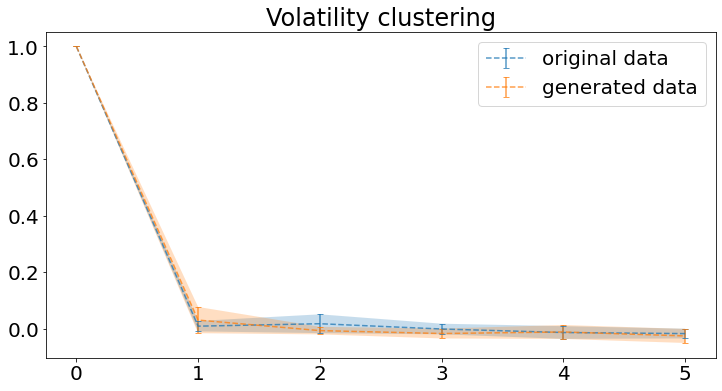

In [34]:
fig = plt.figure(figsize=[12,6])
plt.errorbar(np.arange(0,returns_10[0].shape[1]), np.mean(lagged_autocorrelations, axis=0), yerr=np.std(lagged_autocorrelations, axis=0), alpha=.75, fmt="--", capsize=3, label=data_labels[0])
plt.fill_between(np.arange(0,returns_10[0].shape[1]), np.mean(lagged_autocorrelations, axis=0)-np.std(lagged_autocorrelations, axis=0), np.mean(lagged_autocorrelations, axis=0)+np.std(lagged_autocorrelations, axis=0), alpha=.25)
plt.errorbar(np.arange(0,returns_10[0].shape[1]), np.mean(gen_lagged_autocorrelations, axis=0), yerr=np.std(gen_lagged_autocorrelations, axis=0), alpha=.75, fmt="--", capsize=3, label=data_labels[1])
plt.fill_between(np.arange(0,returns_10[0].shape[1]), np.mean(gen_lagged_autocorrelations, axis=0)-np.std(gen_lagged_autocorrelations, axis=0), np.mean(gen_lagged_autocorrelations, axis=0)+np.std(gen_lagged_autocorrelations, axis=0), alpha=.25)
plt.legend()
plt.title('Volatility clustering');
if save_figs:
    fig.savefig("images/{}_volatility_clustering.png".format(data_type))
    tikzplotlib.save("images/{}_volatility_clustering.tex".format(data_type), encoding="utf-8")

## Total number of events per sequence

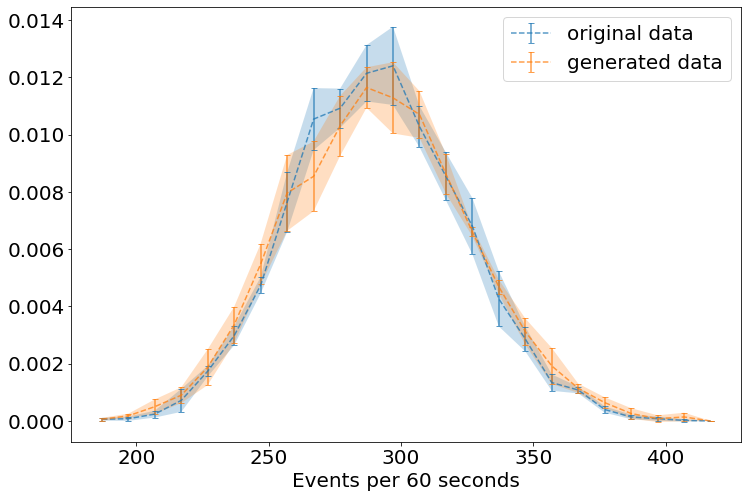

In [35]:
num_events_sequence = [[e.size for e in d["event"]] for d in data_dict_list]
num_events_sequence_gen = [[e.size for e in d["event"]] for d in gen_data_dict_list]
max_num_events = np.max([num_events_sequence, num_events_sequence_gen])
min_num_events = np.min([num_events_sequence, num_events_sequence_gen])
bins = np.arange(min_num_events-1,max_num_events+1,10 if data_type=="mc" else 20)
bin_width = bins[1] - bins[0]
freqs = np.stack([np.histogram(e, density=True, bins=bins)[0] for e in num_events_sequence])
gen_freqs = np.stack([np.histogram(e, density=True, bins=bins)[0] for e in num_events_sequence_gen])
fig1 = plt.figure(figsize=[12, 8])
plt.errorbar((bins[1:] + bins[:-1])/2, np.mean(freqs, axis=0), yerr=np.std(freqs, axis=0), alpha=.75, fmt="--", capsize=3, label=data_labels[0])
plt.fill_between((bins[1:] + bins[:-1])/2, np.mean(freqs, axis=0)-np.std(freqs, axis=0), np.mean(freqs, axis=0)+np.std(freqs, axis=0), alpha=.25)
plt.errorbar((bins[1:] + bins[:-1])/2, np.mean(gen_freqs, axis=0), yerr=np.std(gen_freqs, axis=0), alpha=.75, fmt="--", capsize=3, label=data_labels[1])
plt.fill_between((bins[1:] + bins[:-1])/2, np.mean(gen_freqs, axis=0)-np.std(gen_freqs, axis=0), np.mean(gen_freqs, axis=0)+np.std(gen_freqs, axis=0), alpha=0.25)
plt.xlabel("Events per 60 seconds")
plt.legend();
if save_figs:
    fig.savefig("images/{}_num_events.png".format(data_type))
    tikzplotlib.save("images/{}_num_events.tex".format(data_type), encoding="utf-8")

## Distribution of time between events

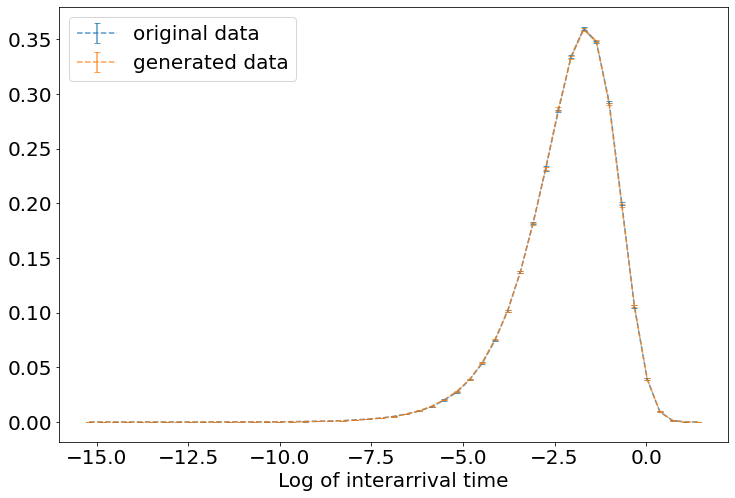

In [36]:
times = [np.concatenate([np.log(t) for t in d[time_str]], axis=0) for d in data_dict_list]
gen_times = [np.concatenate([np.log(t) for t in d[time_str]], axis=0) for d in gen_data_dict_list]
max_times = np.max([[np.max(t) for t in times], [np.max(t) for t in gen_times]])
min_times = np.min([[np.min(t) for t in times], [np.min(t) for t in gen_times]])
bins = np.linspace(min_times-1e-5,max_times+1e-5,50)
bin_width = bins[1] - bins[0]
freqs = np.stack([np.histogram(e, density=True, bins=bins)[0] for e in times])
gen_freqs = np.stack([np.histogram(e, density=True, bins=bins)[0] for e in gen_times])
fig1 = plt.figure(figsize=[12, 8])
plt.errorbar((bins[1:] + bins[:-1])/2, np.mean(freqs, axis=0), yerr=np.std(freqs, axis=0), alpha=.75, fmt="--", capsize=3, label=data_labels[0])
plt.fill_between((bins[1:] + bins[:-1])/2, np.mean(freqs, axis=0)-np.std(freqs, axis=0), np.mean(freqs, axis=0)+np.std(freqs, axis=0), alpha=.25)
plt.errorbar((bins[1:] + bins[:-1])/2, np.mean(gen_freqs, axis=0), yerr=np.std(gen_freqs, axis=0), alpha=.75, fmt="--", capsize=3, label=data_labels[1])
plt.fill_between((bins[1:] + bins[:-1])/2, np.mean(gen_freqs, axis=0)-np.std(gen_freqs, axis=0), np.mean(gen_freqs, axis=0)+np.std(gen_freqs, axis=0), alpha=0.25);
plt.legend();
plt.xlabel("Log of interarrival time");
if save_figs:
    fig.savefig("images/{}_interarrival_time.png".format(data_type))
    tikzplotlib.save("images/{}_interarrival_time.tex".format(data_type), encoding="utf-8")

## Price signatures after market orders

In [37]:
all_dicts = [[{} for i in range(len(data_dict_list[0]["ob"]))] for d in range(num_data)]

for d in range(num_data):
    for k,v in data_dict_list[d].items():
        for i in range(len(v)):
            all_dicts[d][i][k] = v[i].reshape((1,) + v[i].shape)
        
gen_all_dicts = [[{} for i in range(len(data_dict_list[0]["ob"]))] for d in range(num_data)]

for d in range(num_data):
    for k,v in gen_data_dict_list[d].items():
        for i in range(len(v)):
            gen_all_dicts[d][i][k] = v[i].reshape((1,) + v[i].shape)
        
mo_keys = [v for k,v in event_types.items() if k.startswith("mo")]
data_index = [np.isin(d["event"], mo_keys) for d in data_dict]
gen_data_index = [np.isin(d["event"], mo_keys) for d in gen_data_dict]
mo_data_size = [data_dict[d]["size"][data_index[d]] if data_type == "mc" else data_dict[d]["abs_size"][data_index[d]] for d in range(num_data)]
gen_mo_data_size = [gen_data_dict[d]["size"][gen_data_index[d]] if data_type == "mc" else gen_data_dict[d]["abs_size"][gen_data_index[d]] for d in range(num_data)]

mo_time = 10
mo_sig = [[market_order_signatures(d, event_types, timefactor=timefactor, end_time=mo_time, size_limits=None if data_type == "mc" else (10/info[0]["std_size"], np.inf), abs_size=False if data_type == "mc" else True) for d in a] for a in all_dicts]
gen_mo_sig = [[market_order_signatures(d, event_types, timefactor=timefactor, end_time=mo_time, size_limits=None if data_type == "mc" else (10/info[0]["std_size"], np.inf), abs_size=False if data_type == "mc" else True) for d in a] for a in gen_all_dicts]

mo_signatures = [{} for n in range(num_data)]
gen_mo_signatures = [{} for n in range(num_data)]

for n in range(num_data):
    for k,v in mo_sig[n][0].items():
        mo_signatures[n][k] = np.concatenate([m[k] for m in mo_sig[n] if type(m[k]) != int])
        gen_mo_signatures[n][k] = np.concatenate([m[k] for m in gen_mo_sig[n] if type(m[k]) != int])
    if data_type == "nasdaq":
        for k in mo_signatures[0].keys():
            mo_signatures[n][k] = mo_signatures[n][k]/info[0]["std_size"]
            gen_mo_signatures[n][k] = gen_mo_signatures[n][k]/info[0]["std_size"]

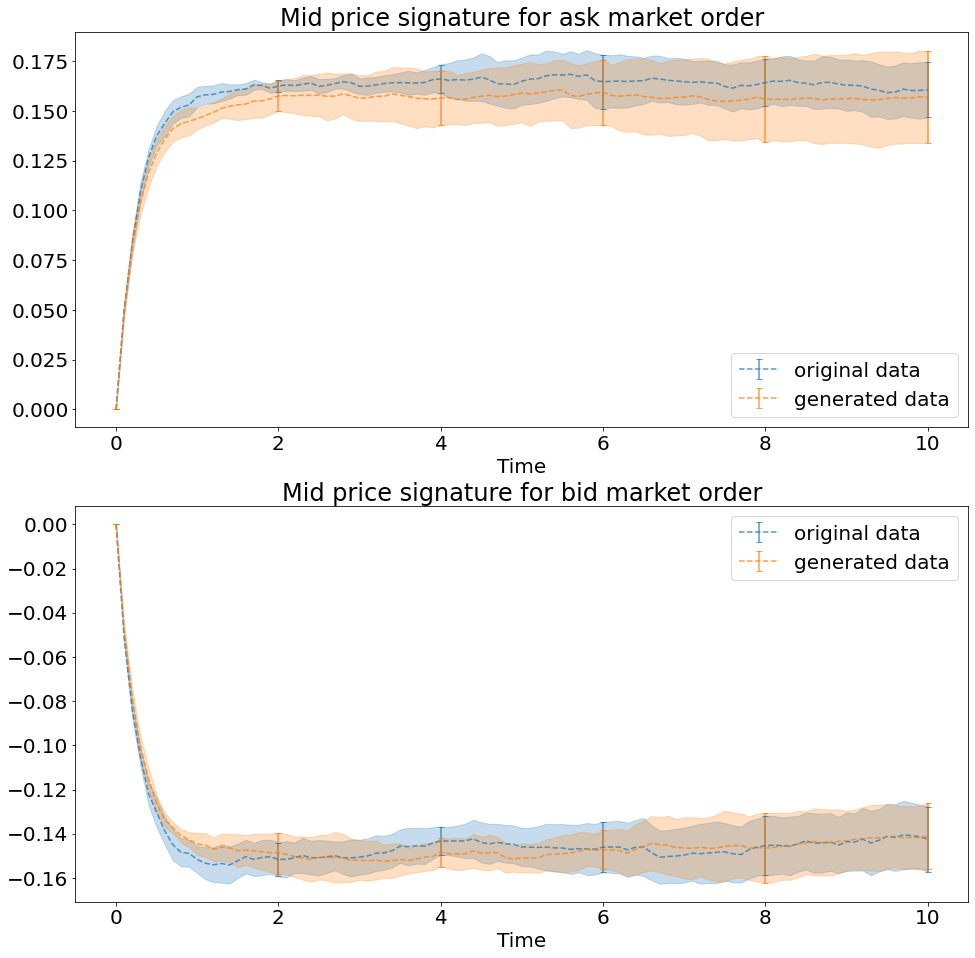

In [38]:
cmap = plt.get_cmap("tab10")
tp = np.arange(mo_signatures[0]["ask"].shape[-1])/timefactor
fig1 = plt.figure(figsize=[16,16])

for i in range(2):
    mo = "ask" if i==0 else "bid"
    ax1 = fig1.add_subplot(2,1,i+1)
    mean_vals = np.stack([np.mean(mo_signatures[n][mo], axis=0) for n in range(num_data)])
    ax1.errorbar(tp, np.mean(mean_vals, axis=0) , yerr=np.std(mean_vals, axis=0), label=data_labels[0], errorevery=20, capsize=3, alpha=.75, fmt="--")
    ax1.fill_between(tp, np.mean(mean_vals, axis=0) - np.std(mean_vals, axis=0), np.mean(mean_vals, axis=0) + np.std(mean_vals, axis=0), color=cmap(0), alpha=.25)
    mean_vals = np.stack([np.mean(gen_mo_signatures[n][mo], axis=0) for n in range(num_data)])
    ax1.errorbar(tp, np.mean(mean_vals, axis=0) , yerr=np.std(mean_vals, axis=0), label=data_labels[1], errorevery=20, capsize=3, alpha=.75, fmt="--")
    ax1.fill_between(tp, np.mean(mean_vals, axis=0) - np.std(mean_vals, axis=0), np.mean(mean_vals, axis=0) + np.std(mean_vals, axis=0), color=cmap(1), alpha=.25)
    ax1.legend()
    ax1.set_title("Mid price signature for {} market order".format(mo));
    ax1.set_xlabel("Time")
    if data_type == "nasdaq":
        ax1.set_ylim((-0.005, 0.005))
        
if save_figs:
    fig1.savefig("images/{}_mo_impact.png".format(data_type))
    tikzplotlib.save("images/{}_mo_impact.tex".format(data_type), encoding="utf-8")

# KS statistics

## Load data simulated with naive model to benchmark against

In [39]:
naive_seeds = (111, 211, 311, 411, 511)
naive_data_dict_list = []
naive_data = []
naive_gen_data = []
naive_data_dict = []
naive_gen_data_dict = []
naive_gen_data_dict_list = []

for s in naive_seeds:
    naive_data_dict_list.append(pickle.load( open( "../data/{}_naive_model_data_{}.pkl".format(data_type, s), "rb" ) ))
    naive_data.append(naive_data_dict_list[-1]['ob'])
    naive_gen_data.append(naive_data_dict_list[-1]['generated_ob'])
    _ = naive_data_dict_list[-1].pop("event_types")

    naive_data_dict.append({})
    for k,v in naive_data_dict_list[-1].items():
        naive_data_dict[-1][k] = np.concatenate(naive_data_dict_list[-1][k], axis=0)

    naive_gen_data_dict.append({})
    for k in list(naive_data_dict[-1].keys()):
        if k.startswith("generated_"):
            naive_gen_data_dict[-1][k[len("generated_"):]] = naive_data_dict[-1].pop(k)

    naive_gen_data_dict_list.append({})
    for k in list(naive_data_dict_list[-1].keys()):
        if k.startswith("generated_"):
            naive_gen_data_dict_list[-1][k[len("generated_"):]] = naive_data_dict_list[-1].pop(k) 

In [40]:
naive_data_time_list = [np.concatenate([events_to_times(d["ob"][i].reshape((1,-1,2,num_levels+1)), d[time_str][i].reshape((1,-1)), timefactor=timefactor, end_time=end_time) for i in range(len(d["event"]))]) for d in naive_data_dict_list] 
naive_gen_data_time_list = [np.concatenate([events_to_times(d["ob"][i].reshape((1,-1,2,num_levels+1)), d[time_str][i].reshape((1,-1)), timefactor=timefactor, end_time=end_time) for i in range(len(d["event"]))]) for d in naive_gen_data_dict_list]
naive_data_oi = [np.apply_along_axis(lambda x: LOB(x).order_imbalance(5), -1, d.reshape((d.shape[0], d.shape[1],-1))) for d in naive_data_time_list]
naive_gen_data_oi = [np.apply_along_axis(lambda x: LOB(x).order_imbalance(5), -1, d.reshape((d.shape[0], d.shape[1],-1))) for d in naive_gen_data_time_list]
naive_data_spreads = [np.apply_along_axis(lambda x: LOB(x).spread,-1,d.reshape(d.shape[:-2] + (-1,))) for d in naive_data_time_list]
naive_gen_data_spreads = [np.apply_along_axis(lambda x: LOB(x).spread,-1,d.reshape(d.shape[:-2] + (-1,))) for d in naive_gen_data_time_list]
naive_data_mids = [mid_func(d) for d in naive_data_time_list]
naive_gen_data_mids = [mid_func(d) for d in naive_gen_data_time_list]
naive_data_return = [np.diff(d, axis=-1) for d in naive_data_mids]
naive_gen_data_return = [np.diff(d, axis=-1) for d in naive_gen_data_mids]
seq_length = info[0]["seq_length_time"]
naive_data_vol = [realized_vol(mid_func(d), seq_length=seq_length) for d in naive_data_time_list]
naive_gen_data_vol = [realized_vol(mid_func(d), seq_length=seq_length) for d in naive_gen_data_time_list]

In [41]:
data_oi = [np.apply_along_axis(lambda x: LOB(x).order_imbalance(5), -1, d.reshape((d.shape[0], d.shape[1],-1))) for d in data_time_list]
gen_data_oi = [np.apply_along_axis(lambda x: LOB(x).order_imbalance(5), -1, d.reshape((d.shape[0], d.shape[1],-1))) for d in gen_data_time_list]
data_vol = [realized_vol(mid_func(d), seq_length=seq_length) for d in data_time_list]
gen_data_vol = [realized_vol(mid_func(d), seq_length=seq_length) for d in gen_data_time_list]

In [42]:
df = pd.DataFrame(columns=("Distribution", "RNN model", "Naive model"))
idx = 0
ordering = []
for k in ["event", "level", "size", "abs_size", "time", "abs_time"]:
    if k in data_dict[0].keys():
        for i in range(num_data):
            ks = ks_2samp(data_dict[i][k].flatten(), gen_data_dict[i][k].flatten())
            ks_naive = ks_2samp(naive_data_dict[i][k].flatten(), naive_gen_data_dict[i][k].flatten())
            df.loc[idx] = [k, ks[0], ks_naive[0]]
            idx += 1
        ordering.append(k)

In [43]:
for k, v in zip(["oi", "spread", "return", "vol"], [(data_oi, gen_data_oi, naive_data_oi, naive_gen_data_oi), (data_spreads, gen_data_spreads, naive_data_spreads, naive_gen_data_spreads), (data_return, gen_data_return, naive_data_return, naive_gen_data_return,), (data_vol, gen_data_vol, naive_data_vol, naive_gen_data_vol)]):
    for i in range(num_data):
        ks = ks_2samp(v[0][i].flatten(), v[1][i].flatten())
        ks_naive = ks_2samp(v[2][i].flatten(), v[3][i].flatten())
        df.loc[idx] = [k, ks[0], ks_naive[0]]
        idx += 1
    ordering.append(k)

In [44]:
df

,Distribution,RNN model,Naive model
0,event,0.001174,0.007167
1,event,0.000460,0.007065
2,event,0.000576,0.009193
3,event,0.002775,0.009065
4,event,0.001375,0.006995
5,level,0.002991,0.035461
6,level,0.002262,0.034834
7,level,0.002922,0.036005
8,level,0.003426,0.038905
9,level,0.003213,0.041012


In [45]:
table_filename = "ks_{}.tex".format(data_type)
grouped, code = make_table(df,
                     ["Distribution"], ["RNN model", "Naive model"],
                     ordering=ordering)
with open(table_filename, "w") as fp:
    fp.write(code)

{'event': (0.00219676321427724, False), 'level': (0.003401986668570358, False), 'oi': (0.029487231735816445, False), 'return': (0.0007549699303609148, False), 'size': (0.0017298619075275896, False), 'spread': (0.024072308636164812, False), 'time': (0.0036684379808331006, False), 'vol': (0.031791550061325446, False)}


In [46]:
grouped

RNN model           Naive model          
                  mean       std        mean       std
Distribution                                          
event         0.001272  0.000925    0.007897  0.001127
level         0.002963  0.000439    0.037243  0.002621
size          0.001310  0.000420    0.002172  0.000273
time          0.002461  0.001207    0.008899  0.001113
oi            0.018014  0.011474    0.122835  0.005469
spread        0.015782  0.008290    0.112170  0.004270
return        0.000573  0.000182    0.011492  0.000240
vol           0.026920  0.004872    0.293760  0.003726